# PREPROCESS DATA

Data downloaded with `scripts/download_58540.sh`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

from astropy.io import fits

from glob import glob
from tqdm.auto import tqdm
from os.path import join, basename

In [2]:
DATA_DIR = '/scratch/ch4407/lbc/58540/'
OUTPUT_DIR = '/scratch/ch4407/lbc/58540-processed/'

## Extract the headers

In [3]:
try:
    df = pd.read_csv(join(DATA_DIR, "headers.csv"))
except FileNotFoundError:
    filenames = sorted(glob(f"{DATA_DIR}/*.fit.gz"))
    headers = [None] * len(filenames)
    for i, filename in enumerate(tqdm(filenames, desc="Reading headers")):
        with fits.open(filename) as f:
            headers[i] = dict(f[0].header)
    df = pd.DataFrame(headers)
    df.to_csv(join(DATA_DIR, "headers.csv"))

## Get the arcs

In [4]:
arcs = df.loc[df["FLAVOR"] == "arc"]
arc_exposures = np.unique(arcs["EXPOSURE"])

## Specifying columns of interest

In [5]:
# find the interesting columns
cols_of_interest = [
    x
    for x in df.loc[:, df.nunique() > 1].columns
    if x not in ["FILENAME", "CAMERAS", "EXPOSURE"]
]

print(cols_of_interest)

['Unnamed: 0', 'ERRCNT', 'SYNCERR', 'SLINES', 'PFERR', 'DIDFLUSH', 'FLAVOR', 'TAI-BEG', 'DATE-OBS', 'NAME', 'PLATEID', 'CARTID', 'MAPID', 'SRVYMODE', 'OBJSYS', 'RA', 'DEC', 'RADEG', 'DECDEG', 'SPA', 'ROTTYPE', 'ARCOFFX', 'ARCOFFY', 'GUIDOFFR', 'AZ', 'ALT', 'IPA', 'FOCUS', 'M2PISTON', 'M2XTILT', 'M2YTILT', 'M2XTRAN', 'M2YTRAN', 'M2ZROT', 'M1PISTON', 'M1XTRAN', 'M1ZROT', 'SCALE', 'PRESSURE', 'WINDD', 'WINDS', 'GUSTD', 'GUSTS', 'AIRTEMP', 'DEWPOINT', 'TRUSTEMP', 'HUMIDITY', 'DUSTA', 'DUSTB', 'WINDD25M', 'WINDS25M', 'FF', 'NE', 'HGCD', 'FFS', 'MGDPOS', 'MGDRA', 'MGDDEC', 'GUIDER1', 'SLITID1', 'SLITID2', 'GUIDERN', 'COLLA', 'COLLB', 'COLLC', 'HARTMANN', 'MC1HUMHT', 'MC1HUMCO', 'MC1TEMDN', 'MC1THT', 'MC1TRCB', 'MC1TRCT', 'MC1TBCB', 'MC1TBCT', 'REQTIME', 'EXPTIME', 'DARKTIME', 'LN2TEMP', 'CCDTEMP', 'IONPUMP', 'CHECKSUM', 'DATASUM', 'SHOPETIM', 'SHCLOTIM', 'MC2HUMHT', 'MC2HUMCO', 'MC2TEMDN', 'MC2THT', 'MC2TRCB', 'MC2TRCT', 'MC2TBCB', 'MC2TBCT']


## Processing an arc image

In [6]:
def get_image(exp_num):
    exposure = df.loc[
        (df["CAMERAS"] == "r2") & (df["EXPOSURE"] == exp_num)
    ].squeeze()
    
    filename = join(DATA_DIR, exposure.FILENAME + ".gz")
    return fits.getdata(filename)

[[2595 2597 2597 ... 2543 2546 2545]
 [2595 2594 2595 ... 2546 2546 2548]
 [2595 2596 2595 ... 2545 2545 2546]
 ...
 [2553 2554 2551 ... 2748 2746 2748]
 [2554 2553 2553 ... 2750 2743 2746]
 [2551 2551 2554 ... 2749 2751 2749]]


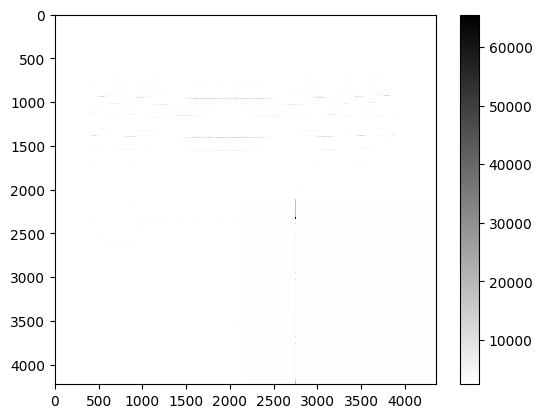

In [7]:
exp_num = arc_exposures[0]
img = get_image(exp_num)
print(img)

plt.imshow(img, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()

In [8]:
def split_by_amplifier(image_data, red=True):
    if red:
        return (
            (
                image_data[48 : 2111 + 1, 119 : 2175 + 1],
                image_data[48 : 2111 + 1, 10 : 100 + 1],
            ),
            (
                image_data[48 : 2111 + 1, 2176 : 4232 + 1],
                image_data[48 : 2111 + 1, 4250 : 4340 + 1],
            ),
            (
                image_data[2112 : 4175 + 1, 119 : 2175 + 1],
                image_data[2112 : 4175 + 1, 10 : 100 + 1],
            ),
            (
                image_data[2112 : 4175 + 1, 2176 : 4232 + 1],
                image_data[2112 : 4175 + 1, 4250 : 4340 + 1],
            ),
        )

    else:
        return (
            (
                image_data[56 : 2111 + 1, 128 : 2175 + 1],
                image_data[56 : 2111 + 1, 10 : 67 + 1],
            ),
            (
                image_data[56 : 2111 + 1, 2176 : 4223 + 1],
                image_data[56 : 2111 + 1, 4284 : 4340 + 1],
            ),
            (
                image_data[2112 : 4167 + 1, 128 : 2175 + 1],
                image_data[2112 : 4167 + 1, 10 : 67 + 1],
            ),
            (
                image_data[2112 : 4167 + 1, 2176 : 4223 + 1],
                image_data[2112 : 4167 + 1, 4284 : 4340 + 1],
            ),
        )

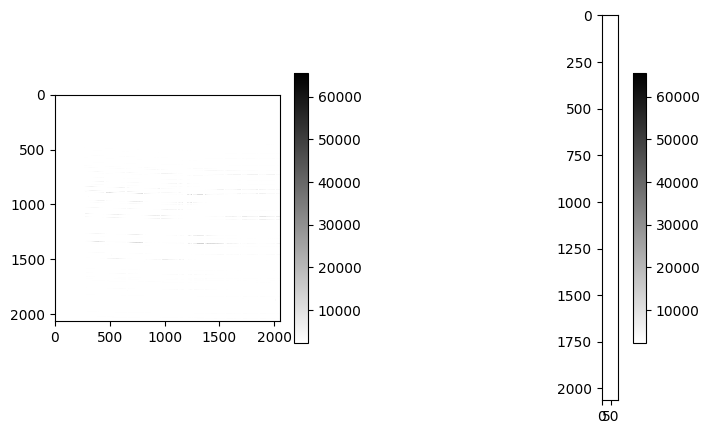

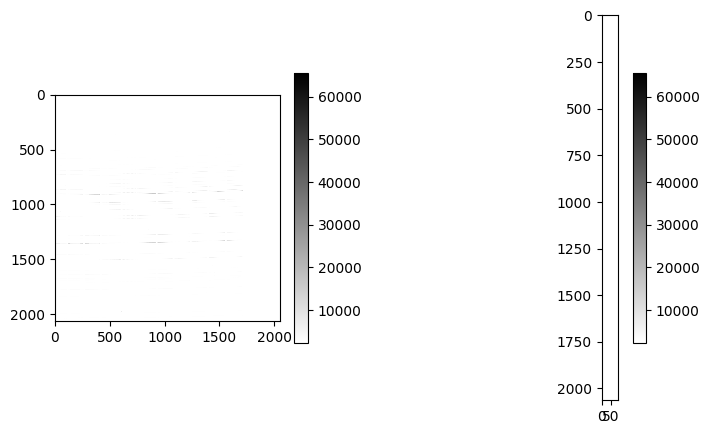

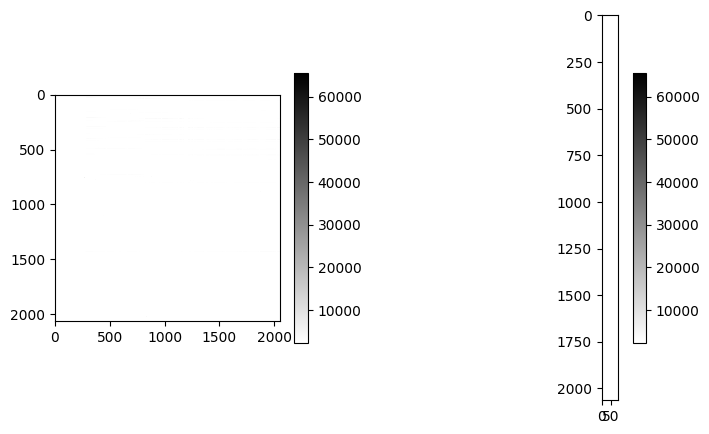

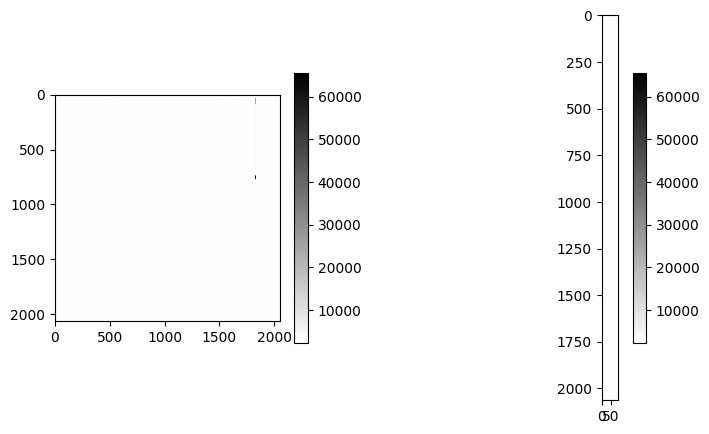

In [9]:
splits = split_by_amplifier(img, red=True)

for data, bias in splits:
    vmin = img.min()
    vmax = img.max()
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 5))
    im = axs[0].imshow(data, cmap='binary', interpolation='nearest', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[0], shrink=0.7)
    im = axs[1].imshow(bias, cmap='binary', interpolation='nearest', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[1], shrink=0.7)
    plt.show()
    
quads = [ data - np.median(bias) for data, bias in splits ]

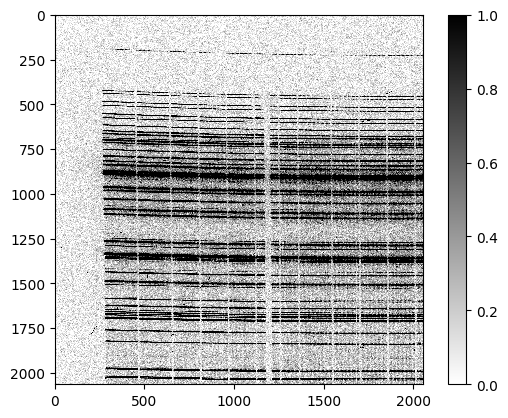

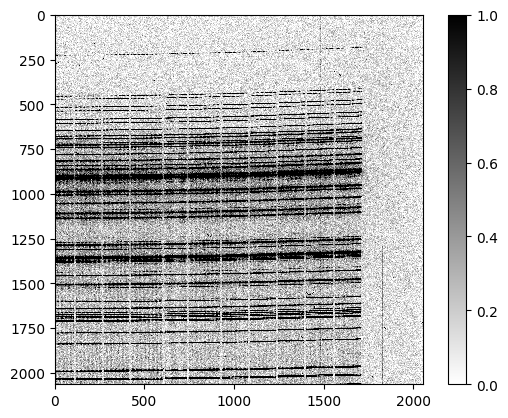

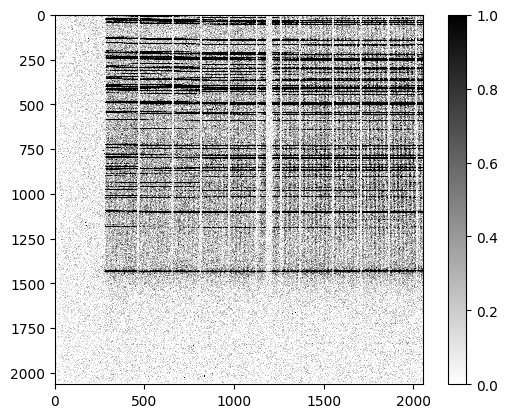

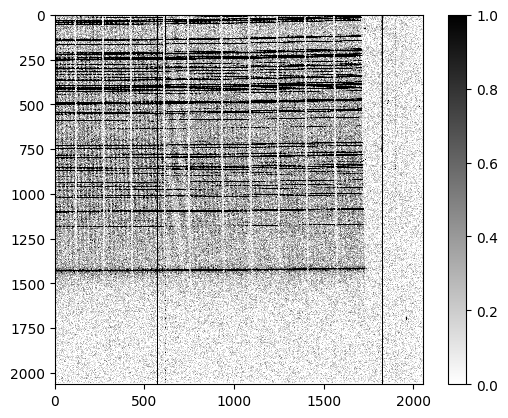

In [10]:
def squash(X):
    median = np.median(X[X != 0])
    width = np.median(np.abs(X[X != 0] - median))
    
    vmin = max(median - 5 * width, 0)
    vmax = median + 5 * width
    
    # clamp all data to between these values
    X[X < vmin] = vmin
    X[X > vmax] = vmax
    
    # scale to [0, 1]
    X -= vmin
    X /= (vmax - vmin)
    return X

# squash
s_quads = [squash(X) for X in quads]

for X in s_quads:
    plt.imshow(X, cmap='binary', interpolation='nearest') #, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

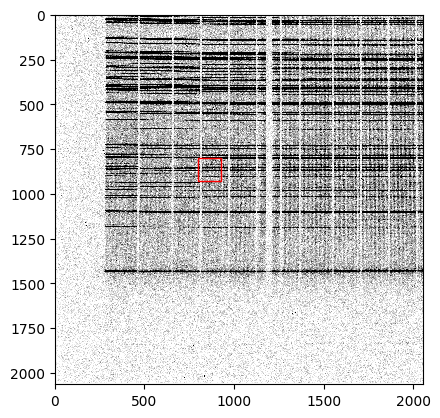

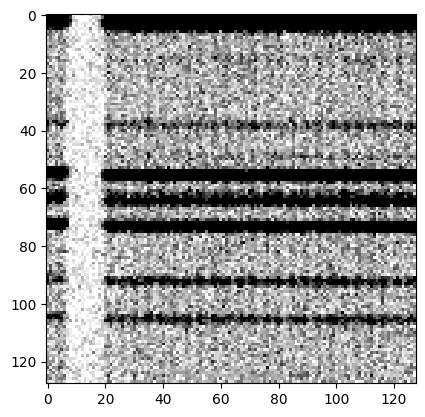

In [11]:
# Now we're just going to take a 128x128 chunk from one of these
# Arbitrarily choose third quadrant:

final = s_quads[2][800:928, 800:928]

plt.imshow(s_quads[2], cmap='binary', interpolation='nearest')
rect = Rectangle((800, 800), 128, 128, facecolor='none', edgecolor='red')
ax = plt.gca()
ax.add_patch(rect)
plt.show()


plt.imshow(final, cmap='binary', interpolation='nearest')
plt.show()

In [15]:
def process_image(exp_num, return_quad=False):
    img = get_image(exp_num)
    
    splits = split_by_amplifier(img, red=True)
    quads = [ squash(data - np.median(bias)) for data, bias in splits ]
    final = quads[2][800:928, 800:928]
    
    if return_quad:
        return final, quads[2]
    else:
        return final

In [13]:
arc_exposures

array([284109, 284110, 284111, 284112, 284114, 284115, 284116, 284117,
       284119, 284120, 284121, 284130, 284131, 284132, 284133, 284144,
       284146, 284147, 284148, 284153, 284154, 284155, 284164, 284165,
       284166])

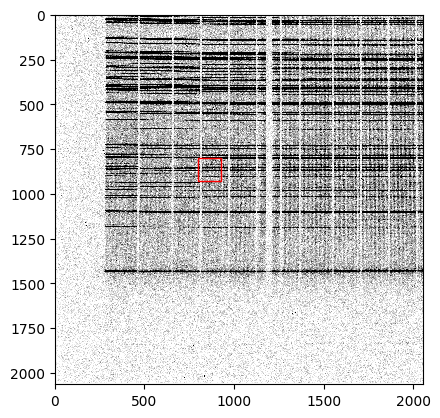

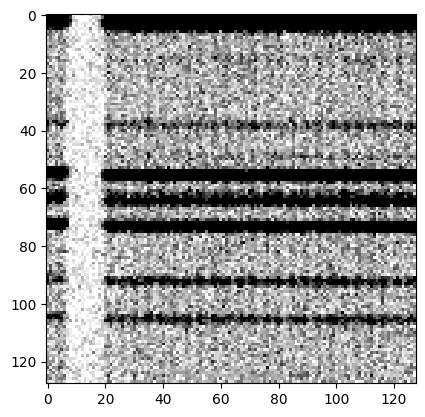

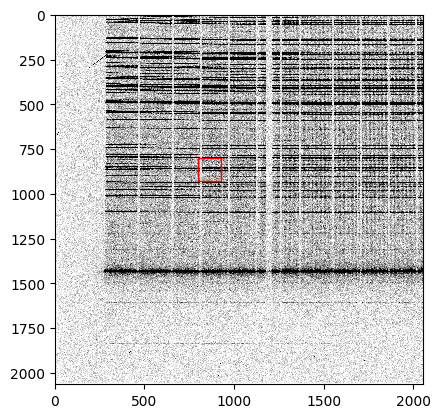

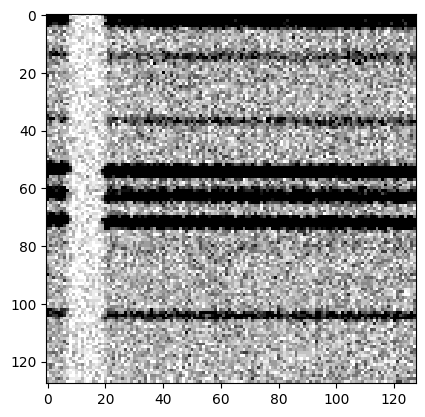

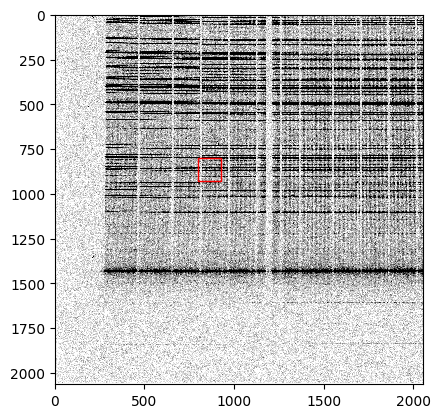

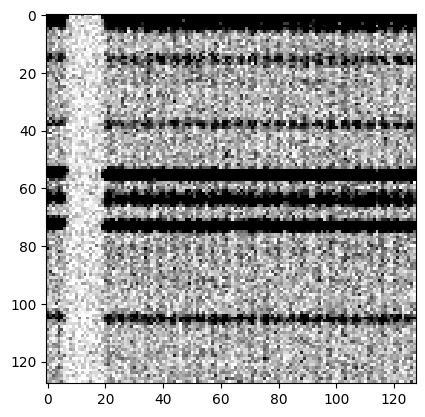

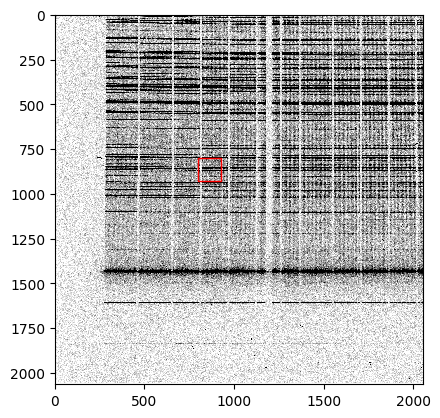

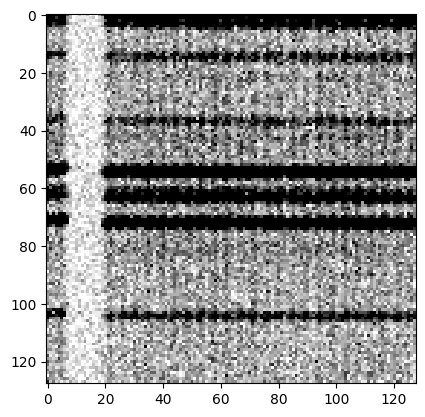

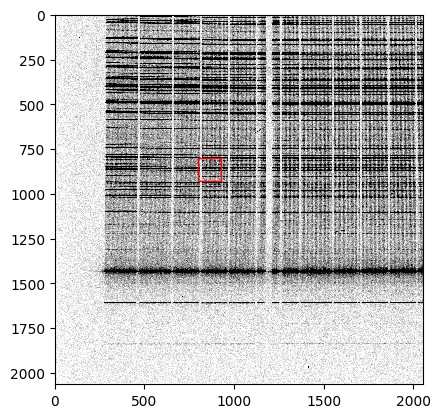

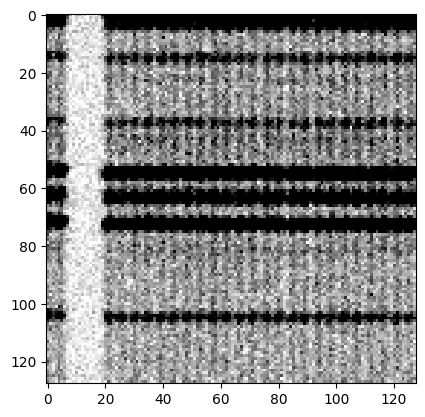

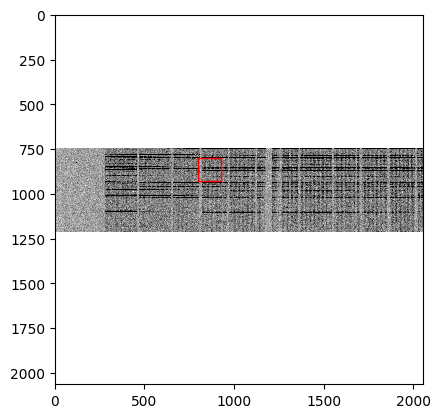

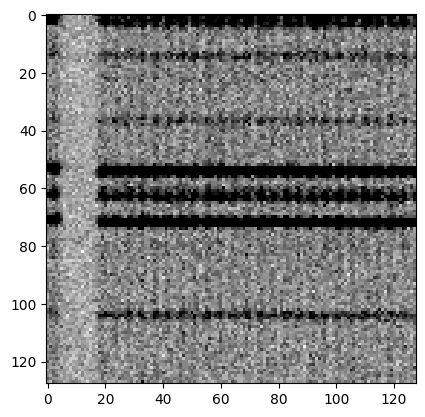

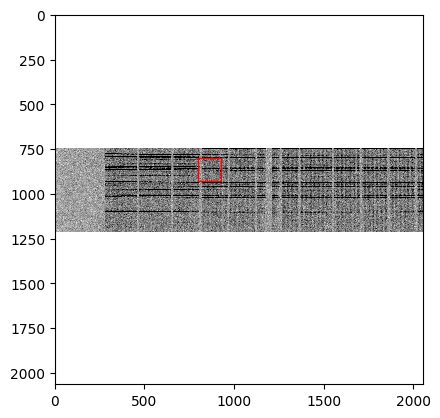

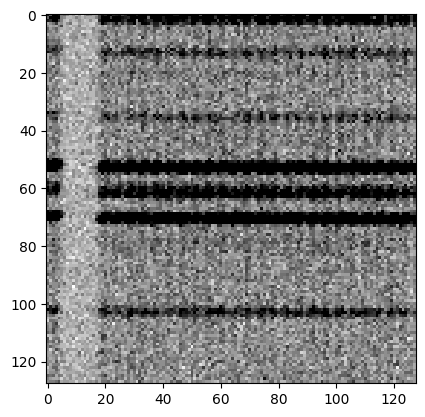

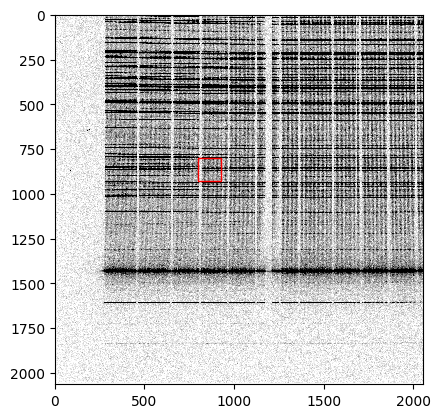

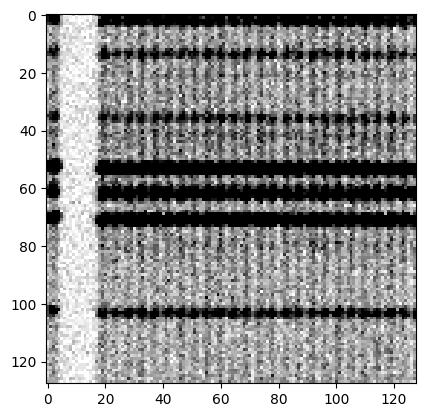

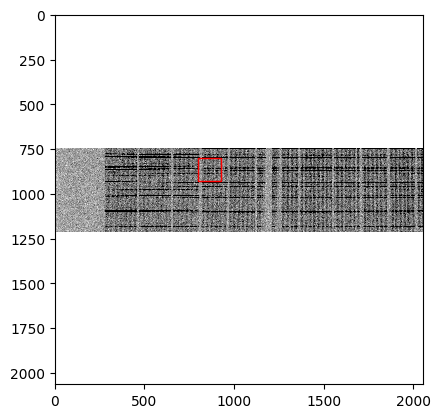

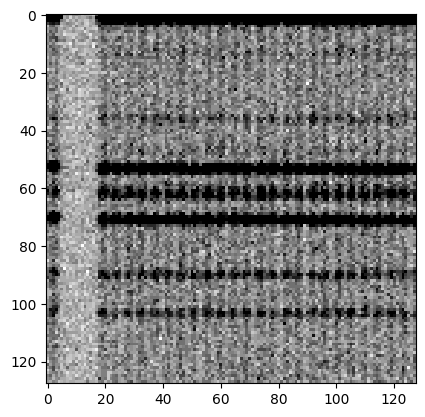

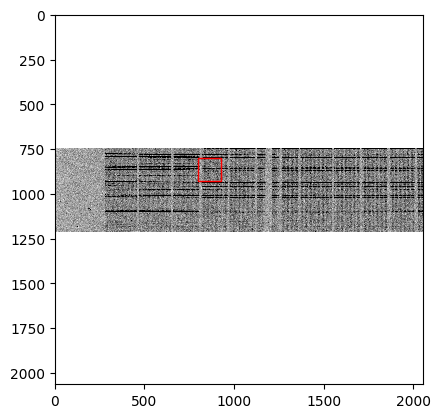

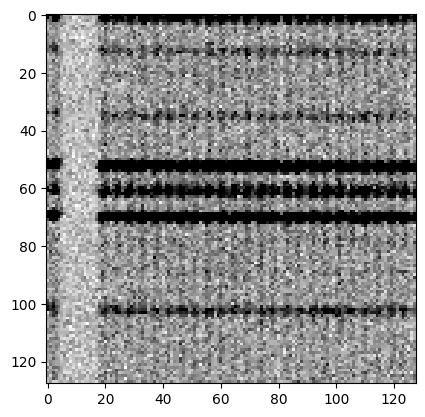

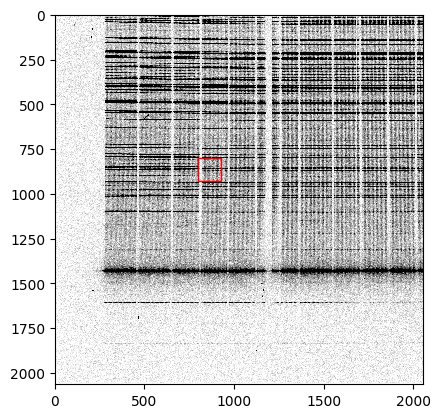

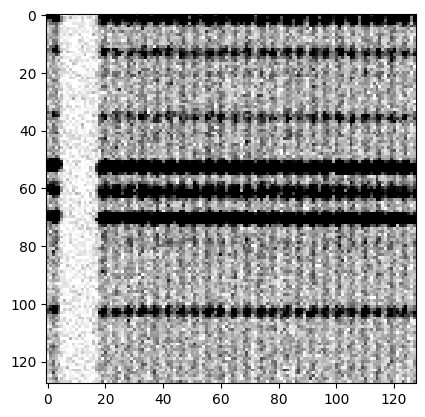

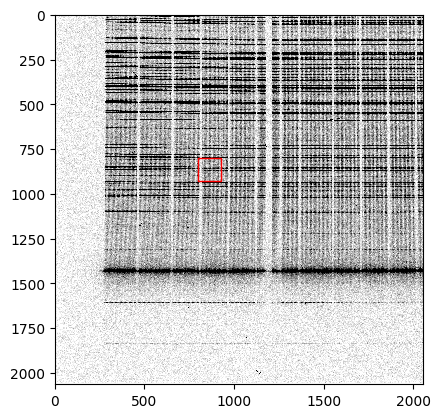

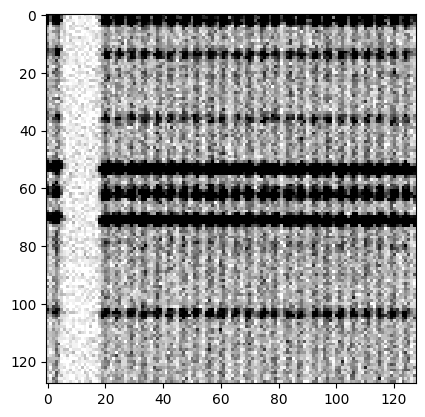

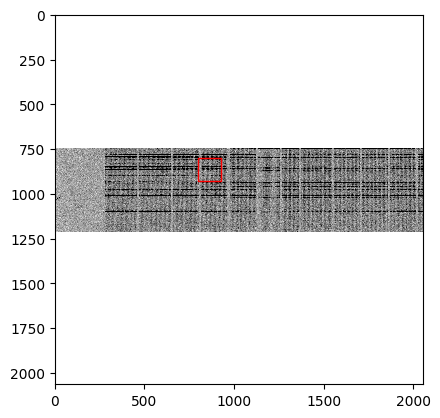

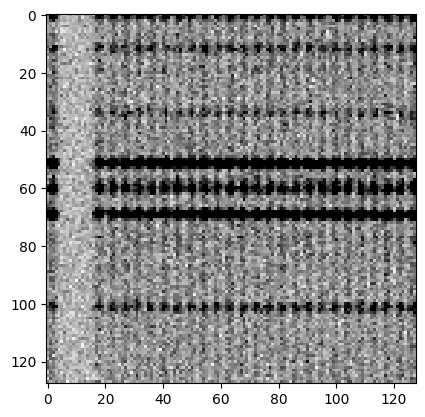

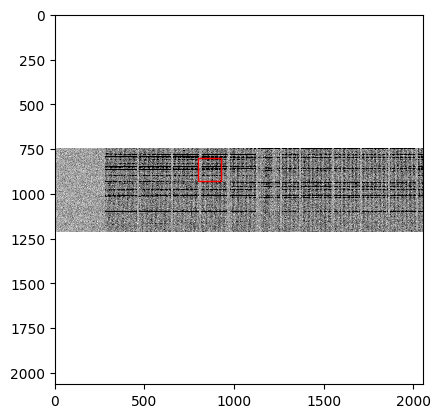

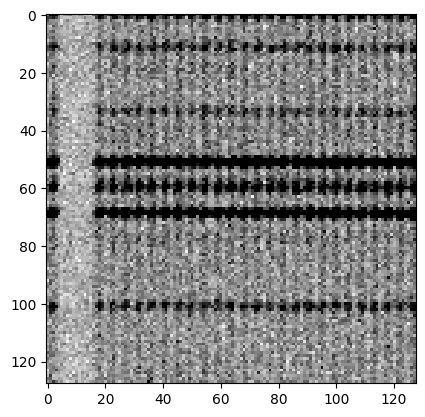

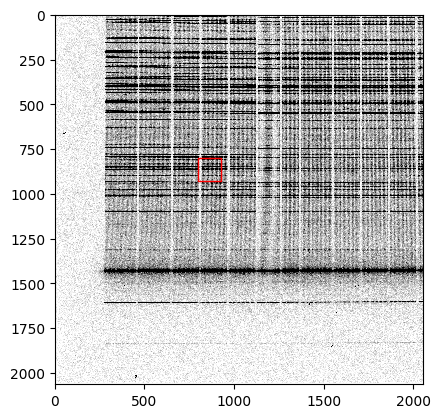

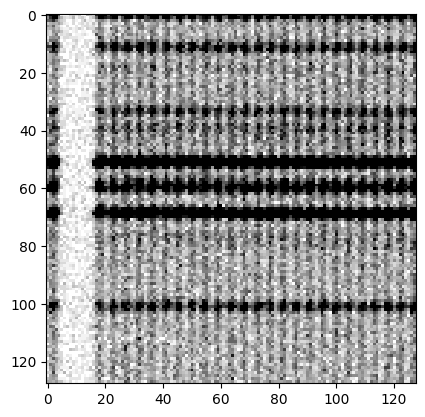

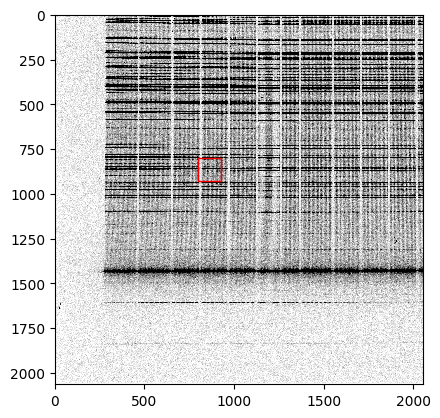

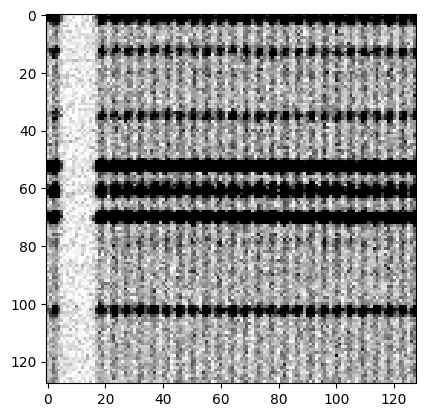

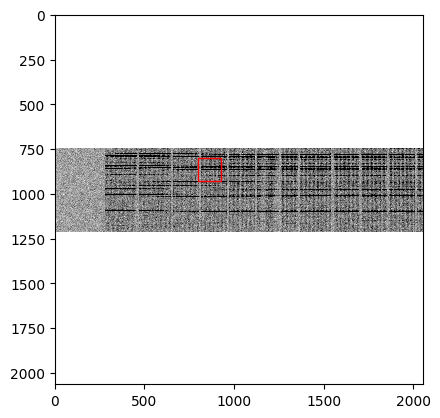

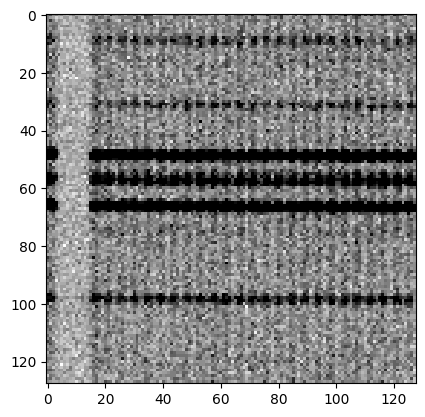

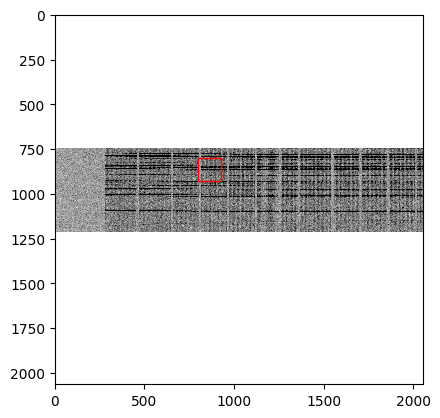

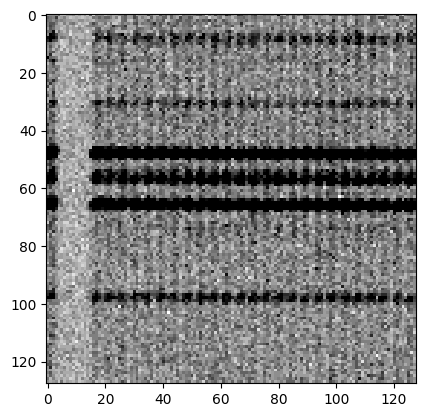

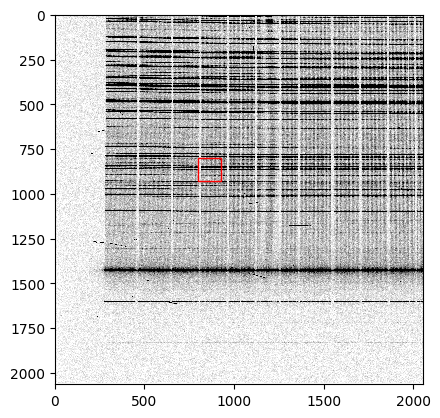

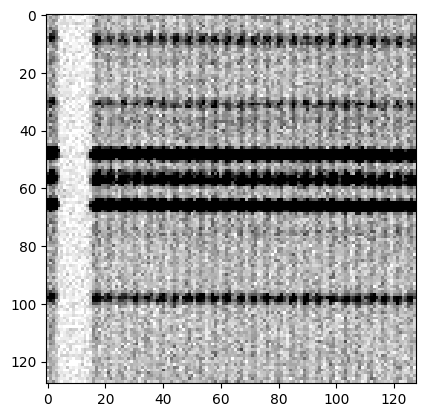

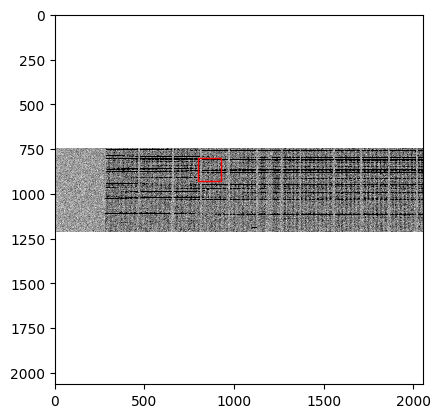

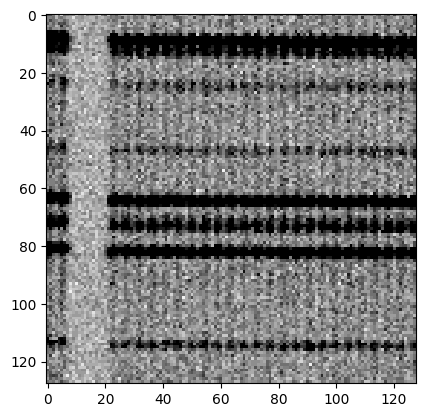

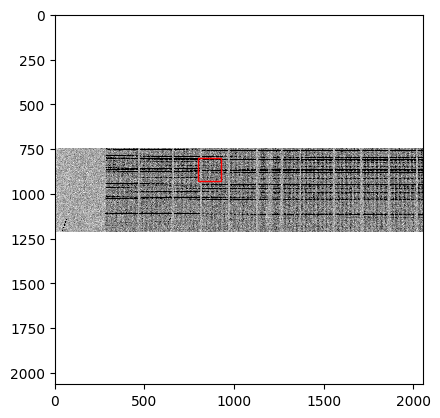

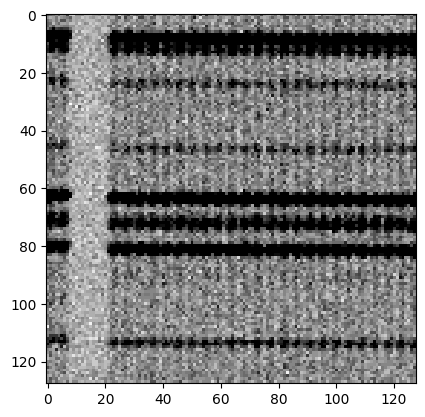

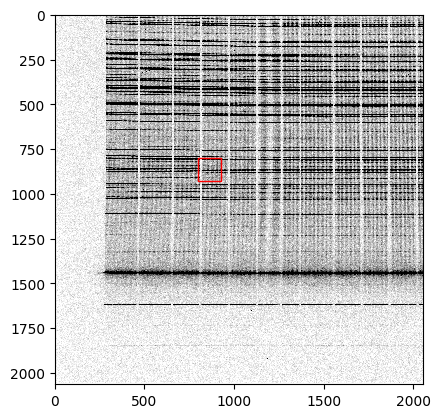

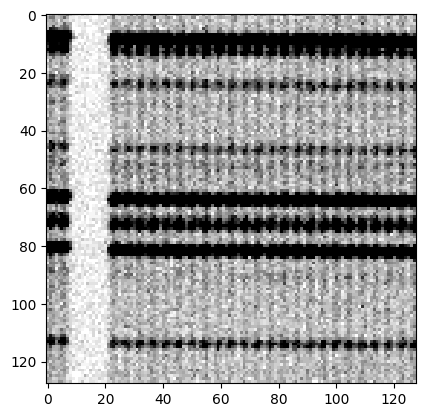

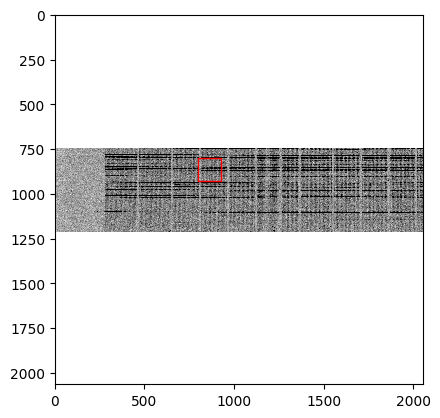

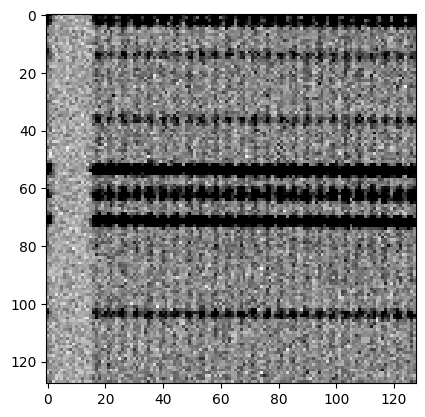

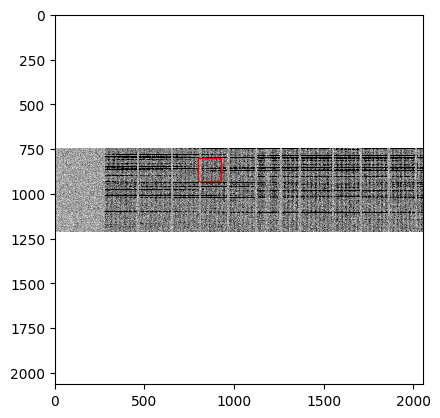

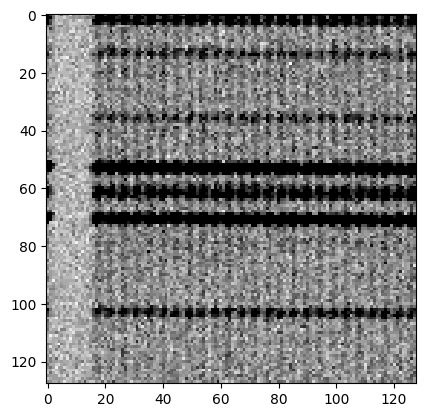

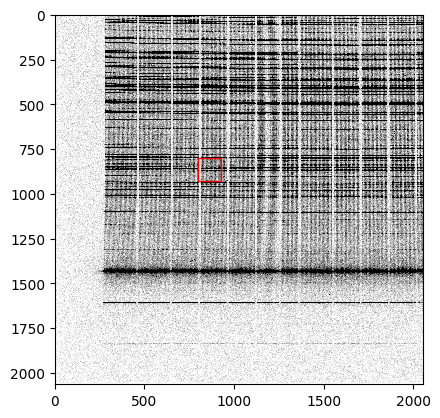

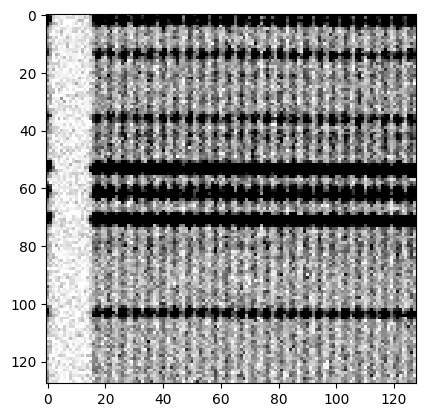

In [16]:
for exp_num in arc_exposures:
    img, quad = process_image(exp_num, return_quad=True)
    
    plt.imshow(quad, cmap='binary', interpolation='nearest')
    rect = Rectangle((800, 800), 128, 128, facecolor='none', edgecolor='red')
    ax = plt.gca()
    ax.add_patch(rect)
    plt.show()

    plt.imshow(img, cmap='binary', interpolation='nearest')
    plt.show()

## Processing all the images

In [14]:
raise ValueError('stop!')

ValueError: stop!

In [17]:
all_metadata = []

for exp_num in arc_exposures:
    # extract the metadata
    exposure = df.loc[
        (df["CAMERAS"] == "r2") & (df["EXPOSURE"] == exp_num)
    ].squeeze()
    metadata = exposure[cols_of_interest]

    # extract a cropped image
    image = process_image(exp_num)
    print(image)

    # save
    all_metadata.append(metadata)
    out_filename = exposure.FILENAME.replace(".fit", ".npy")
    np.save(join(OUTPUT_DIR, out_filename), image)

pd.DataFrame(all_metadata).to_csv(join(OUTPUT_DIR, "metadata.csv"))

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.53846154 0.30769231 0.15384615 ... 0.46153846 0.23076923 0.        ]
 [0.46153846 0.61538462 0.15384615 ... 0.07692308 0.30769231 0.30769231]
 [0.23076923 0.07692308 0.15384615 ... 0.         0.46153846 0.23076923]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.         0.15384615 0.38461538 ... 0.07692308 0.38461538 0.07692308]
 [0.38461538 0.30769231 0.15384615 ... 0.61538462 0.61538462 0.61538462]
 [0.46153846 0.23076923 0.30769231 ... 0.46153846 0.15384615 0.23076923]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 